In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [19]:
df = pd.read_csv('../data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


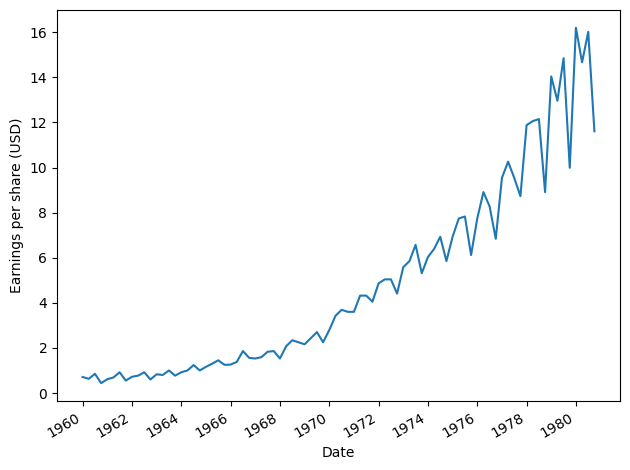

In [20]:
fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH07_F02_peixeiro.png', dpi=300)

In [21]:
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574784
p-value: 1.0


In [22]:
eps_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.40740976363805026
p-value: 0.9088542416911298


In [23]:
eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.585162874793176
p-value: 0.006051099869603258


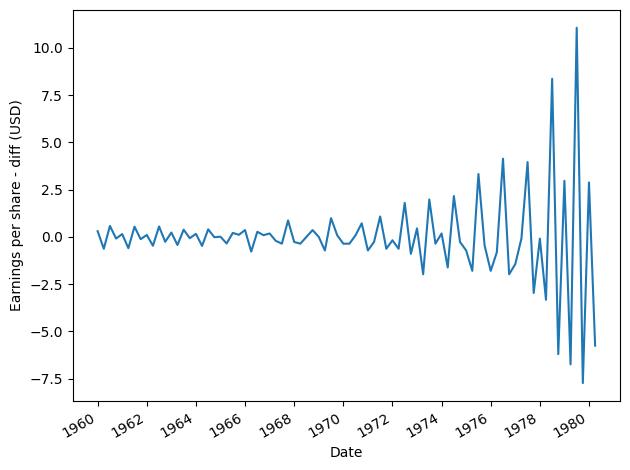

In [24]:
fig, ax = plt.subplots()

ax.plot(df['date'][2:], eps_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH07_F01_peixeiro.png', dpi=300)

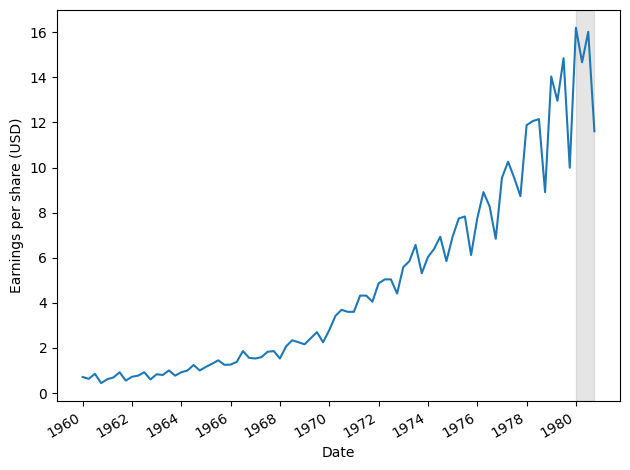

In [25]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH07_F06_peixeiro.png', dpi=300)

In [26]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [27]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))

In [32]:
train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

In [ ]:
model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('figures/CH07_F07_peixeiro.png', dpi=300)

In [ ]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

In [ ]:
test = df.iloc[-4:]

test['naive_seasonal'] = df['data'].iloc[76:80].values
test

In [ ]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH07_F08_peixeiro.png', dpi=300)

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

In [ ]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH07_F09_peixeiro.png', dpi=300)